<a href="https://colab.research.google.com/github/lovnishverma/Python-Getting-Started/blob/main/bikes_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Seoul Bike Sharing Demand - Regression Analysis

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import copy

### Dataset:
Dua, D. and Graff, C. (2019). UCI Machine Learning Repository [https://archive.ics.uci.edu/dataset/560/seoul+bike+sharing+demand]. Irvine, CA: University of California, School of Information and Computer Science.

Source: Data Source :http://data.seoul.go.kr/
SOUTH KOREA PUBLIC HOLIDAYS. URL: publicholidays.go.kr

[Download Dataset from my Github](https://github.com/lovnishverma/datasets/blob/main/SeoulBikeData.csv)


# ----------------------- Dataset Loading -----------------------

In [4]:
dataset_cols = [
    "bike_count", "hour", "temp", "humidity", "wind",
    "visibility", "dew_pt_temp", "radiation", "rain", "snow", "functional"
]

df = pd.read_csv("SeoulBikeData.csv", encoding="ISO-8859-1")
df = df.drop(columns=["Date", "Holiday", "Seasons"])
df.columns = dataset_cols

# ----------------------- Preprocessing -----------------------

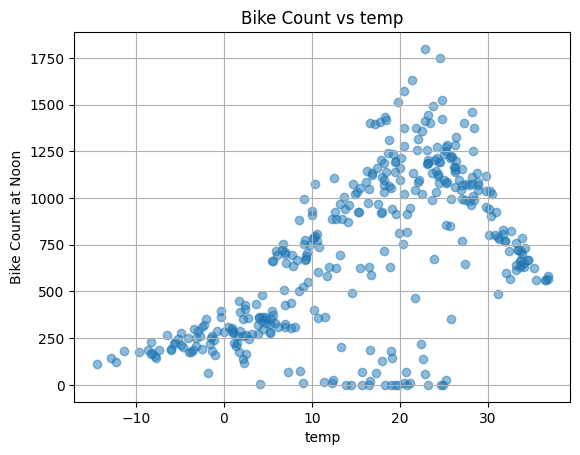

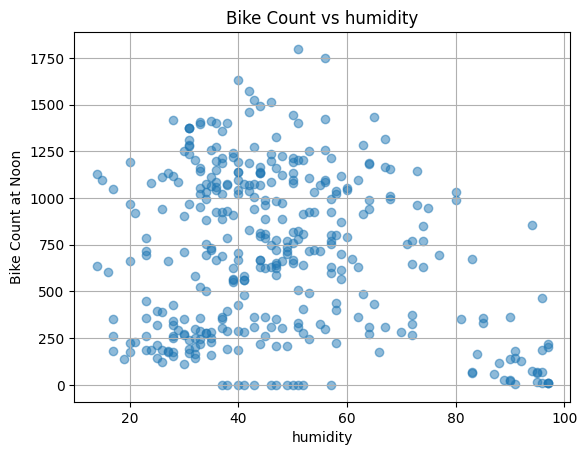

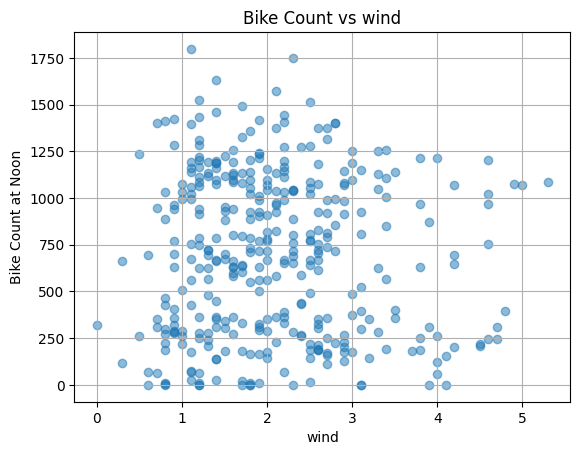

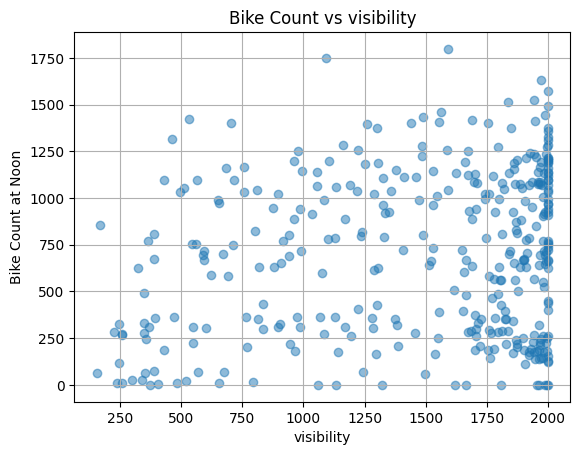

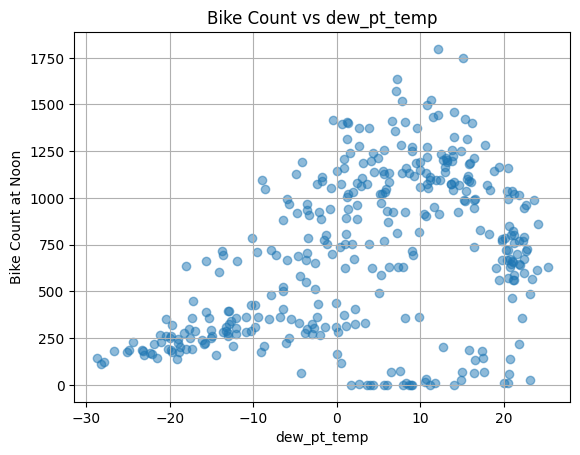

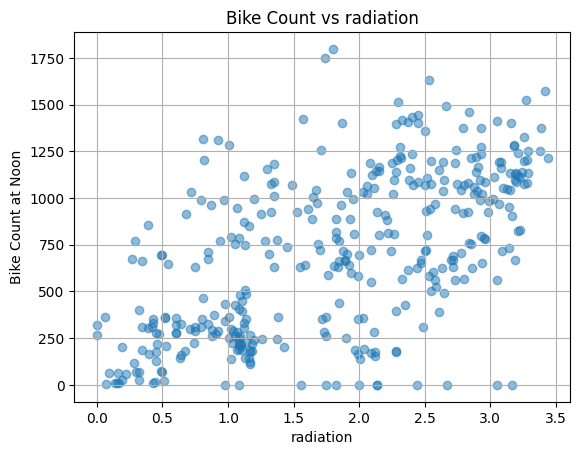

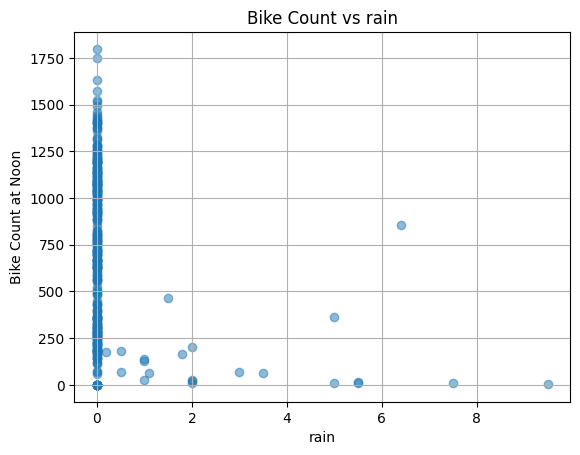

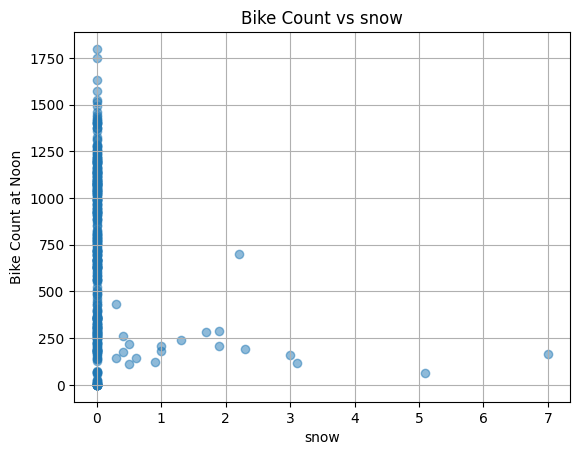

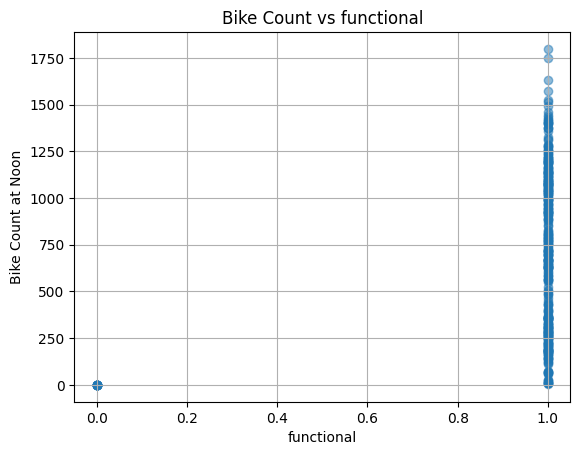

In [5]:
df["functional"] = (df["functional"] == "Yes").astype(int)
df = df[df["hour"] == 12].drop(columns=["hour"])  # Only keep noon data

# Plot relationships
for label in df.columns[1:]:
    plt.figure()
    plt.scatter(df[label], df["bike_count"], alpha=0.5)
    plt.title(f"Bike Count vs {label}")
    plt.xlabel(label)
    plt.ylabel("Bike Count at Noon")
    plt.grid(True)
    plt.show()

# Remove low-impact features
df = df.drop(columns=["wind", "visibility", "functional"])

# ----------------------- Data Splitting -----------------------

In [6]:
train, val, test = np.split(df.sample(frac=1, random_state=42), [int(0.6*len(df)), int(0.8*len(df))])

def get_xy(dataframe, y_label, x_labels=None):
    dataframe = copy.deepcopy(dataframe)
    if x_labels is None:
        X = dataframe.drop(columns=[y_label]).values
    else:
        X = dataframe[x_labels].values if isinstance(x_labels, list) else dataframe[[x_labels]].values
    y = dataframe[[y_label]].values
    return np.hstack((X, y)), X, y

/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


# ----------------------- Simple Linear Regression (Temp) -----------------------

R^2 on test set: 0.1724911525262579


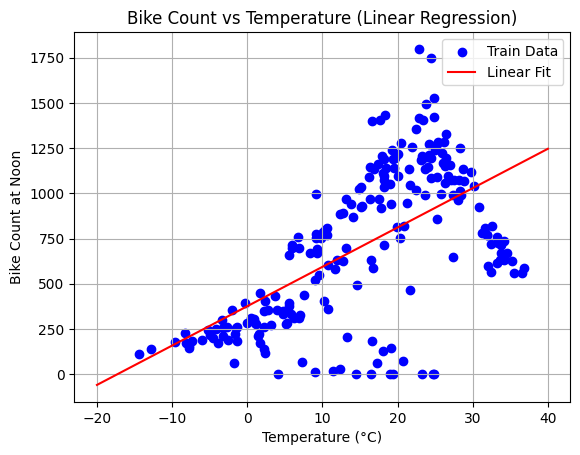

In [7]:
_, X_train_temp, y_train_temp = get_xy(train, "bike_count", x_labels="temp")
_, X_val_temp, y_val_temp = get_xy(val, "bike_count", x_labels="temp")
_, X_test_temp, y_test_temp = get_xy(test, "bike_count", x_labels="temp")

temp_reg = LinearRegression().fit(X_train_temp, y_train_temp)
print("R^2 on test set:", temp_reg.score(X_test_temp, y_test_temp))

# Plot
plt.figure()
plt.scatter(X_train_temp, y_train_temp, label="Train Data", color="blue")
x_vals = tf.linspace(-20, 40, 100)
plt.plot(x_vals, temp_reg.predict(np.array(x_vals).reshape(-1, 1)), label="Linear Fit", color="red")
plt.title("Bike Count vs Temperature (Linear Regression)")
plt.xlabel("Temperature (°C)")
plt.ylabel("Bike Count at Noon")
plt.legend()
plt.grid(True)
plt.show()

This means:

17.25% of the variation in bike counts at noon is explained by our model using temperature as the only feature.

The remaining 82.75% of the variation is not captured by the model — suggesting that temperature alone is not a strong predictor of bike demand at noon.



# ----------------------- Multiple Linear Regression -----------------------

In [8]:
_, X_train_all, y_train_all = get_xy(train, "bike_count")
_, X_val_all, y_val_all = get_xy(val, "bike_count")
_, X_test_all, y_test_all = get_xy(test, "bike_count")

multi_reg = LinearRegression().fit(X_train_all, y_train_all)
print("Multivariate R^2 on test set:", multi_reg.score(X_test_all, y_test_all))
y_pred_lr = multi_reg.predict(X_test_all)

Multivariate R^2 on test set: 0.46190870435014986


What It Tells us:

Including more features improves the model — as expected.

But 53.8% of the variation is still unexplained, which could be due to:

Unused but relevant features (e.g., hour, holiday, weekday/weekend, season)

Non-linear relationships that linear regression can't capture

Noise or unmeasured factors (e.g., public events, road closures)



# ----------------------- Neural Network (Temp Only) -----------------------

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


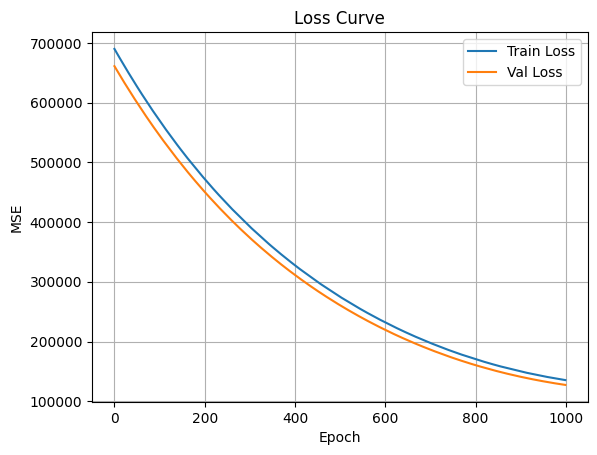

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


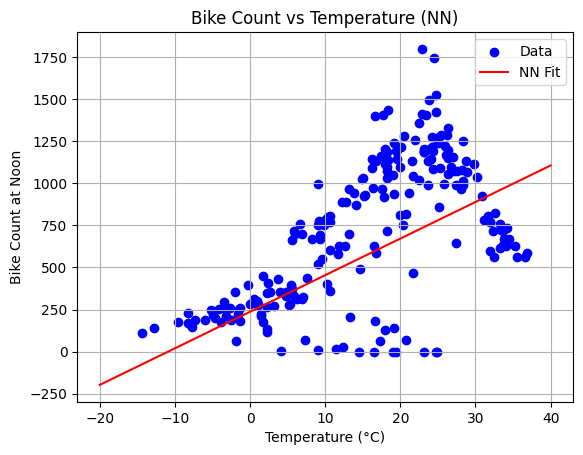

In [9]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title("Loss Curve")
    plt.xlabel("Epoch")
    plt.ylabel("MSE")
    plt.legend()
    plt.grid(True)
    plt.show()

# Normalize input
temp_norm = tf.keras.layers.Normalization(input_shape=(1,), axis=None)
temp_norm.adapt(X_train_temp)

temp_nn_model = tf.keras.Sequential([
    temp_norm,
    tf.keras.layers.Dense(1)
])

temp_nn_model.compile(optimizer=tf.keras.optimizers.Adam(0.1), loss='mean_squared_error')

history = temp_nn_model.fit(X_train_temp, y_train_temp, validation_data=(X_val_temp, y_val_temp),
                            epochs=1000, verbose=0)

plot_loss(history)

# Plot predictions
plt.figure()
plt.scatter(X_train_temp, y_train_temp, label="Data", color="blue")
x_vals = tf.linspace(-20, 40, 100)
plt.plot(x_vals, temp_nn_model.predict(np.array(x_vals).reshape(-1, 1)), color="red", label="NN Fit")
plt.title("Bike Count vs Temperature (NN)")
plt.xlabel("Temperature (°C)")
plt.ylabel("Bike Count at Noon")
plt.legend()
plt.grid(True)
plt.show()

# ----------------------- Neural Network (All Features) -----------------------

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


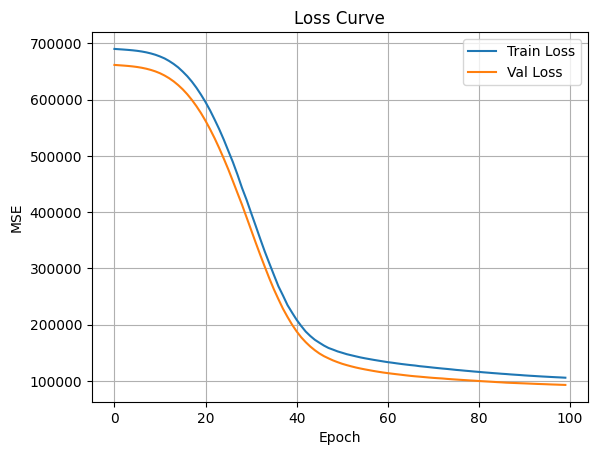

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step 


In [10]:
all_norm = tf.keras.layers.Normalization(input_shape=(X_train_all.shape[1],))
all_norm.adapt(X_train_all)

full_nn_model = tf.keras.Sequential([
    all_norm,
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

full_nn_model.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss='mean_squared_error')

history = full_nn_model.fit(X_train_all, y_train_all, validation_data=(X_val_all, y_val_all),
                            epochs=100, verbose=0)

plot_loss(history)

y_pred_nn = full_nn_model.predict(X_test_all)


# ----------------------- Evaluation: MSE -----------------------

In [11]:
def MSE(y_pred, y_true):
    return np.mean(np.square(y_pred - y_true))

print("MSE (Linear Regression):", MSE(y_pred_lr, y_test_all))
print("MSE (Neural Network):   ", MSE(y_pred_nn, y_test_all))

MSE (Linear Regression): 105289.89154460563
MSE (Neural Network):    111146.96277967826


### Model Performance Summary

| Model             | R² Score  | MSE        |
| ----------------- | --------- | ---------- |
| Linear Regression | 0.462     | 105,289.89 |
| Neural Network    | (unknown) | 111,146.96 |

---

### Interpretation

#### **Linear Regression performed better** than the Neural Network in this case.

* **Lower MSE**: Linear Regression has a lower average squared prediction error.
* Neural Network has **higher MSE**, meaning it made larger errors on average.

---

## Why did the Neural Network perform worse?

Despite being more flexible, neural networks don’t always outperform linear models, especially when:

### 1. **Data is small**

Neural networks need a large dataset to shine. If your data only contains \~700 rows (as in noon-filtered bike data), linear models often perform better.

### 2. **Simple relationships**

If the relationships between features and output are **mostly linear**, then a simple linear model fits well, and neural nets don’t add much.

### 3. **Undertraining or overfitting**

Possible issues in your NN:

* Too **small network** or too **short training**: underfit
* Too **complex network**: overfit to training set, generalizes poorly

You can test this by checking:

```python
plt.plot(history.history['loss'], label="Train")
plt.plot(history.history['val_loss'], label="Validation")
```

If validation loss goes up while training loss goes down → overfitting.

---

## What You Can Try to Improve the Neural Network

### 1. **Train on all hours**

Filter on `hour == 12` limits data. Try training on full dataset with `hour` as a feature.

### 2. **Tune the Neural Network**

Try different:

* Architectures: `Dense(64) → Dense(64) → Dense(1)`
* Activation functions: `relu`, `elu`, `selu`
* Regularization: `Dropout`, `L2 kernel_regularizer`
* Epochs and batch size

Example:

```python
nn_model = tf.keras.Sequential([
    tf.keras.layers.Normalization(input_shape=(X_train_all.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])
```

---

* Linear Regression is performing **better** in our case, likely due to **data size**, **linearity**, and **low model variance**.
* Neural networks are **powerful**, but not magic — they need **careful tuning** and **enough data** to outperform simpler models.

---


# ----------------------- Final Comparison Plot -----------------------

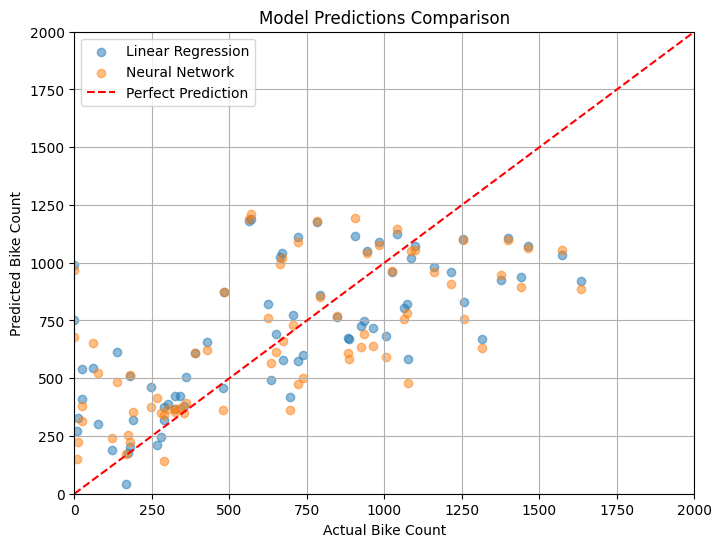

In [12]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test_all, y_pred_lr, alpha=0.5, label="Linear Regression")
plt.scatter(y_test_all, y_pred_nn, alpha=0.5, label="Neural Network")
lims = [0, 2000]
plt.plot(lims, lims, 'r--', label="Perfect Prediction")
plt.xlim(lims)
plt.ylim(lims)
plt.xlabel("Actual Bike Count")
plt.ylabel("Predicted Bike Count")
plt.title("Model Predictions Comparison")
plt.legend()
plt.grid(True)
plt.show()

**📌 Notes:**

Dataset used is "[SeoulBikeData.csv](https://github.com/lovnishverma/datasets/blob/main/SeoulBikeData.csv)" upload it to google colab.

Both regression models use data filtered to only 12 PM for consistency.

Features "wind", "visibility", and "functional" are dropped due to poor correlation (you can reintegrate and test if needed).

Neural Network architectures are shallow and fast to train but accurate enough for demonstration.